1) Libraries

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Optuna
import optuna
from optuna import TrialPruned

# Sklearn utilities
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.preprocessing import RobustScaler
# ML models
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier



2) Load Data

In [47]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

TARGET = "segment"

# Drop ID columns if exist
id_cols = [col for col in ["id", "player_id"] if col in train.columns]
train = train.drop(columns=id_cols, errors="ignore")
test_ids = test[id_cols] if len(id_cols) > 0 else None
test_X = test.drop(columns=id_cols, errors="ignore")



In [48]:
train.head()

,play_frequency,avg_session_duration,total_playtime_hours,login_streak,days_since_last_login,total_spending_thb,avg_monthly_spending,spending_frequency,friend_count,team_play_percentage,...,platform,device_type,payment_method,language,account_status,player_type_tag,engagement_level,loyalty_tier,skill_tier,segment
0,5.495437,24.837349,2740.945124,60.0,56.034052,58219.915660,434.038311,17.790970,58.0,NaN,...,PC,Phone,Wallet,DE,Active,Social,Low,Silver,NaN,0
1,9.991089,88.376322,NaN,22.0,75.036888,28966.163953,4233.532935,28.862134,276.0,52.789877,...,Console,Desktop,Card,ES,Dormant,Collector,Low,Platinum,Gold,2
2,14.234225,101.712292,2828.479467,66.0,NaN,44478.823835,4849.491895,22.536406,71.0,58.267306,...,PC,Laptop,NaN,EN,Dormant,Casual,High,Diamond,Gold,3
3,3.373683,191.975841,1915.082950,80.0,0.127910,57074.116993,6863.516123,10.565666,105.0,67.274038,...,Console,Tablet,NaN,ES,Dormant,Competitive,Veteran,Silver,Gold,3
4,22.469353,28.042509,517.921948,NaN,45.078460,NaN,4408.101247,11.226504,111.0,NaN,...,PC,Tablet,Gift,EN,Active,Casual,Mid,Silver,NaN,1


3) Outlier Removal — Isolation Forest

In [49]:
numeric_cols = train.select_dtypes(include=["float64", "int64"]).columns.drop(TARGET)
iso = IsolationForest(contamination=0.03, random_state=42)
outlier_pred = iso.fit_predict(train[numeric_cols])
train_clean = train[outlier_pred == 1].reset_index(drop=True)
print("Outliers removed:", (outlier_pred == -1).sum())

Outliers removed: 3050


4) Encode target if categorical

In [50]:
y = train_clean[TARGET]
if y.dtype == 'object':
    le = LabelEncoder()
    y = le.fit_transform(y)


5) Feature Selection via Correlation Heatmap

Selected numeric features: ['total_playtime_hours', 'days_since_last_login', 'total_spending_thb', 'avg_monthly_spending', 'spending_frequency', 'rare_items_count', 'vip_tier']


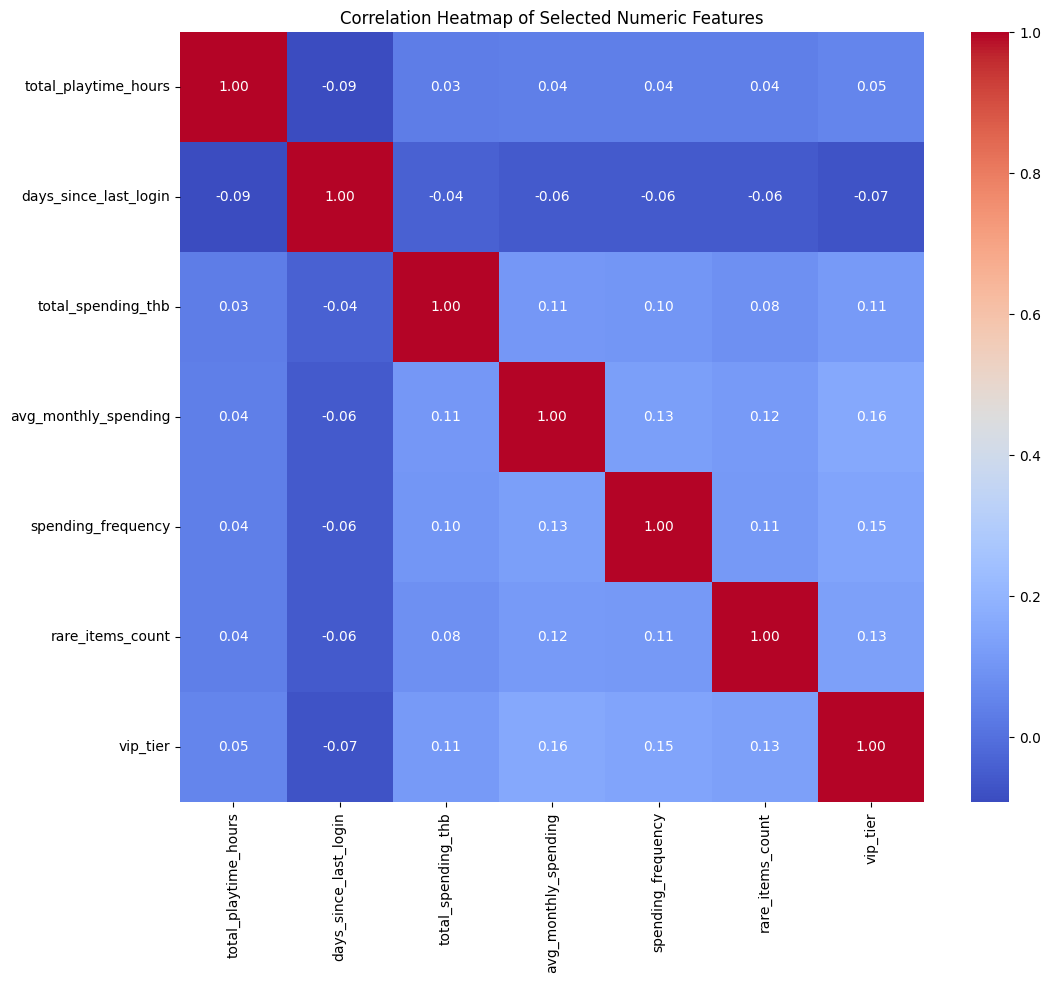

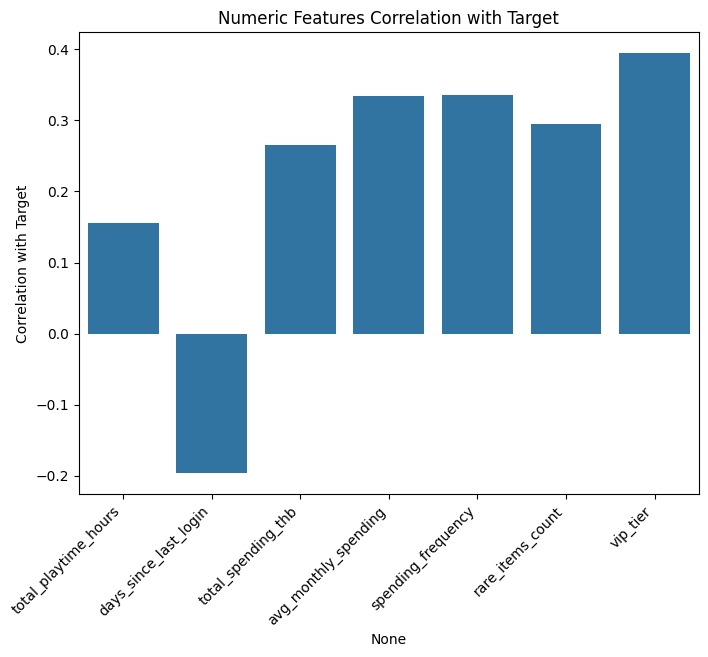

In [51]:
X_num = train_clean[numeric_cols]
corr_with_target = X_num.corrwith(pd.Series(y))
selected_numeric = corr_with_target[abs(corr_with_target) > 0.15].index.tolist()
print("Selected numeric features:", selected_numeric)

categorical_features = train_clean.select_dtypes(include=['object']).columns.tolist()
categorical_features = [c for c in categorical_features if c != TARGET]

X = pd.concat([train_clean[selected_numeric], train_clean[categorical_features]], axis=1)
X_test = pd.concat([test_X[selected_numeric], test_X[categorical_features]], axis=1)

corr_matrix = X_num[selected_numeric].corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap of Selected Numeric Features")
plt.show()

plt.figure(figsize=(8,6))
sns.barplot(x=corr_with_target[selected_numeric].index, y=corr_with_target[selected_numeric].values)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Correlation with Target")
plt.title("Numeric Features Correlation with Target")
plt.show()

6) Fill missing values AFTER feature selection

In [52]:
missing_cols_in_test = set(X.columns) - set(X_test.columns)
for col in missing_cols_in_test:
    X_test[col] = np.nan

X_test = X_test[X.columns]

numeric_cols_selected = selected_numeric
categorical_cols_selected = categorical_features

X_numeric_means = X[numeric_cols_selected].mean()
X_categorical_modes = X[categorical_cols_selected].mode().iloc[0]

X[numeric_cols_selected] = X[numeric_cols_selected].fillna(X_numeric_means)
X[categorical_cols_selected] = X[categorical_cols_selected].fillna(X_categorical_modes)

X_test[numeric_cols_selected] = X_test[numeric_cols_selected].fillna(X_numeric_means)
X_test[categorical_cols_selected] = X_test[categorical_cols_selected].fillna(X_categorical_modes)


7) Scale numeric features

In [53]:


scaler = RobustScaler()
X[selected_numeric] = scaler.fit_transform(X[selected_numeric])
X_test[selected_numeric] = scaler.transform(X_test[selected_numeric])

for col in categorical_features:
    X[col] = X[col].astype('category')
    X_test[col] = X_test[col].astype('category')

In [54]:
X_test

,total_playtime_hours,days_since_last_login,total_spending_thb,avg_monthly_spending,spending_frequency,rare_items_count,vip_tier,region,platform,device_type,payment_method,language,account_status,player_type_tag,engagement_level,loyalty_tier,skill_tier
0,-0.076552,-0.230449,0.922075,0.828164,0.328918,-1.022145,-0.5,AS,PC,Tablet,Gift,EN,Active,Competitive,Mid,Diamond,Gold
1,-0.941644,-0.336473,-0.793512,0.000000,0.075655,0.621691,0.5,EU,Mobile,Laptop,Card,ES,Active,Collector,Mid,Silver,Bronze
2,-0.797026,0.248860,-0.224055,-0.863222,0.732492,-0.392008,-0.5,AS,PC,Phone,Wallet,ES,Dormant,Collector,Low,Bronze,Platinum
3,-0.212481,-0.083844,-0.983752,0.000000,-1.089763,0.114841,-0.5,APAC,PC,Phone,Wallet,ES,Dormant,Competitive,Mid,Bronze,Silver
4,0.270840,-1.175734,-0.908795,-0.648086,0.815620,0.594293,0.0,LATAM,Console,Desktop,Wallet,ES,Dormant,Competitive,Low,Silver,Platinum
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25884,0.000000,-0.705656,0.614076,1.275758,-0.636074,-0.063241,0.0,AS,Console,Desktop,Wallet,DE,Active,Competitive,Mid,Silver,Platinum
25885,-0.265281,-0.142728,-0.001361,0.671044,-0.799568,0.649088,-0.5,AS,Console,Phone,Gift,ES,Active,Collector,Veteran,Silver,Gold
25886,1.163937,-1.019080,0.000000,0.000000,1.185202,-0.487898,-0.5,AS,PC,Tablet,Gift,ES,Dormant,Collector,High,Silver,Gold
25887,0.763887,-1.683492,0.562473,-0.052989,-0.434655,-0.802967,-0.5,AS,PC,Desktop,Wallet,DE,Dormant,Social,Low,Bronze,Diamond


8) Define Optuna Objective (CatBoost)

In [55]:
def objective_cat(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 200, 1000),
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'verbose': 0
    }
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []
    
    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        model = CatBoostClassifier(**params)
        model.fit(
            X_train, y_train,
            cat_features=categorical_cols_selected,
            eval_set=(X_val, y_val),
            early_stopping_rounds=50,
            verbose=False
        )
        preds = model.predict(X_val)
        f1_scores.append(f1_score(y_val, preds, average='macro'))
    
    return np.mean(f1_scores)

9) Run Optuna Study

In [56]:
study_cat = optuna.create_study(direction='maximize')
study_cat.optimize(objective_cat, n_trials=12)

print("Best Optuna params:", study_cat.best_params)
print("Best CV F1-score (macro):", study_cat.best_value)

[I 2025-11-24 07:26:13,469] A new study created in memory with name: no-name-19020aae-48d4-461f-a2ff-6a11ac81a76f
[I 2025-11-24 07:28:42,564] Trial 0 finished with value: 0.6756273977132662 and parameters: {'iterations': 621, 'depth': 7, 'learning_rate': 0.7909468539405052, 'l2_leaf_reg': 4.9816955338492335}. Best is trial 0 with value: 0.6756273977132662.
[I 2025-11-24 07:28:42,564] Trial 0 finished with value: 0.6756273977132662 and parameters: {'iterations': 621, 'depth': 7, 'learning_rate': 0.7909468539405052, 'l2_leaf_reg': 4.9816955338492335}. Best is trial 0 with value: 0.6756273977132662.
[I 2025-11-24 08:10:53,410] Trial 1 finished with value: 0.6814417735953329 and parameters: {'iterations': 696, 'depth': 9, 'learning_rate': 0.02267421347083879, 'l2_leaf_reg': 6.79795425442752}. Best is trial 1 with value: 0.6814417735953329.
[I 2025-11-24 08:10:53,410] Trial 1 finished with value: 0.6814417735953329 and parameters: {'iterations': 696, 'depth': 9, 'learning_rate': 0.022674213

Best Optuna params: {'iterations': 696, 'depth': 9, 'learning_rate': 0.02267421347083879, 'l2_leaf_reg': 6.79795425442752}
Best CV F1-score (macro): 0.6814417735953329


10) Train Final CatBoost Model

In [58]:
best_params = study_cat.best_params
final_model = CatBoostClassifier(
    iterations=best_params['iterations'],
    depth=best_params['depth'],
    learning_rate=best_params['learning_rate'],
    l2_leaf_reg=best_params['l2_leaf_reg'],
    verbose=0
)
final_model.fit(X, y, cat_features=categorical_cols_selected)

In [59]:

predictions = final_model.predict(X_test)

if 'le' in locals() or 'le' in globals():
    predictions_decoded = le.inverse_transform(predictions.flatten().astype(int))
else:
    predictions_decoded = predictions.flatten()

if test_ids is not None and len(id_cols) > 0:
    id_column_name = id_cols[0]
    
    submission_df = pd.DataFrame()
    submission_df[id_column_name] = test_ids[id_column_name]
    submission_df['prediction'] = predictions_decoded
    
    submission_df.to_csv("submmission.csv", index=False)
    
    print(f"Submission file 'submmission.csv' created with columns: {list(submission_df.columns)}")
else:
    submission_df = pd.DataFrame({'prediction': predictions_decoded})
    submission_df.to_csv("submmission.csv", index=False)
    
    print("No ID column detected. Submission file 'submmission.csv' created with a single 'prediction' column.")

Submission file 'submmission.csv' created with columns: ['id', 'prediction']


In [60]:
last_draft = pd.read_csv("S.csv")

In [61]:
last_draft['task2'] = predictions

last_draft.to_csv("submission.csv", index=False)